In [453]:
import numpy as np
import matplotlib.pyplot as plt

## Smoothing COVID data

So we'll see how a convolution works on real data.
We'll get the latest mortality figures from **GitHub**.

The [source](https://github.com/CSSEGISandData/COVID-19) is maintained by John Hopkins University.


In [500]:
! ../.g


[master 2f10918] web
 1 file changed, 1236 insertions(+), 1944 deletions(-)
 rewrite PROG/italy.ipynb (77%)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 47.75 KiB | 1.02 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   4ee7cb7..2f10918  master -> master


In [455]:
import requests
import pandas as pd

In [4]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

## Visualising the data again

We'll convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

- If you want to know more [read this in french](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf).
- It's basically a table like in Excel
    - columns have names
    - rows are numbered and accessed using ```iloc```.


In [456]:
df = pd.read_csv('covid_deaths.csv')

From the dates we see this is the latest data

---

## Looking for Italy

France is in the rows 116 - 126

''' df.loc[149] ''' is what we want

In [460]:
country = 149
df.iloc[country]

Province/State        NaN
Country/Region      Italy
Lat               41.8719
Long              12.5674
1/22/20                 0
                   ...   
11/7/20             41063
11/8/20             41394
11/9/20             41750
11/10/20            42330
11/11/20            42953
Name: 149, Length: 299, dtype: object

It's often easier to work with a numpy array of values

In [461]:
deaths = df.iloc[country][4:].values
deaths[-50:]

array([35758, 35781, 35801, 35818, 35835, 35851, 35875, 35894, 35918,
       35941, 35968, 35986, 36002, 36030, 36061, 36083, 36111, 36140,
       36166, 36205, 36246, 36289, 36372, 36427, 36474, 36543, 36616,
       36705, 36832, 36968, 37059, 37210, 37338, 37479, 37700, 37905,
       38122, 38321, 38618, 38826, 39059, 39412, 39764, 40192, 40638,
       41063, 41394, 41750, 42330, 42953], dtype=object)

# Cumulative deaths

this looks pretty smooth

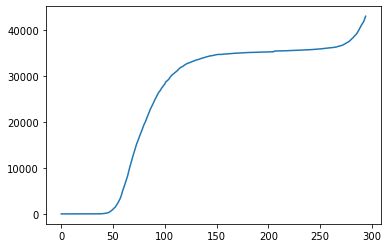

In [462]:
plt.plot(deaths);

But daily figures are noisy

I should use ```np.diff``` to do this.
We get the same graph.

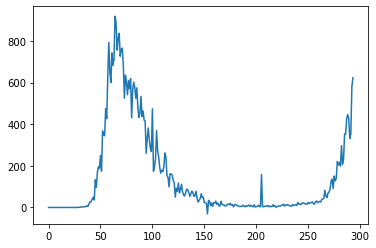

In [466]:
daily = np.diff(deaths,1)
plt.plot(daily);

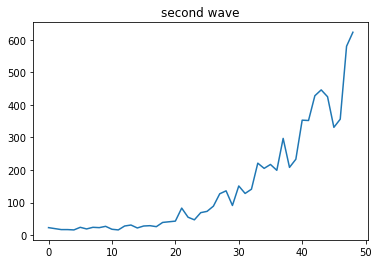

In [467]:
plt.plot(daily[-49:])
plt.title('second wave');

---

## Weekdays

The data is not too noisy.


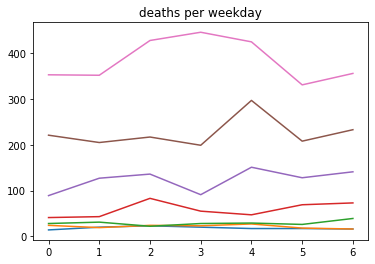

In [468]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

In [469]:
df.columns.tolist()[-9:-2]

['11/3/20', '11/4/20', '11/5/20', '11/6/20', '11/7/20', '11/8/20', '11/9/20']

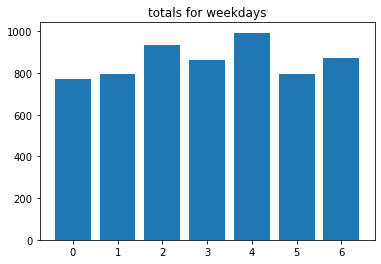

In [470]:
plt.bar(np.arange(7), np.sum(weeks, axis=0))
#plt.plot(np.sum(weeks, axis=0))
plt.title('totals for weekdays');

## Smoothing



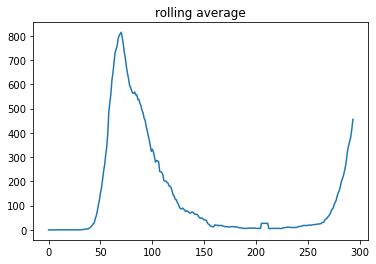

In [471]:
rolling_av = np.convolve(daily, np.ones(7)/7)[:-6]

plt.plot( rolling_av)
plt.title('rolling average');

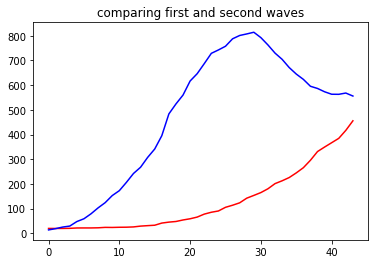

In [485]:
plt.plot(rolling_av[250:],'r')
plt.plot(rolling_av[41:85],'b');
plt.title('comparing first and second waves');

# Exponential  growth in deaths ?

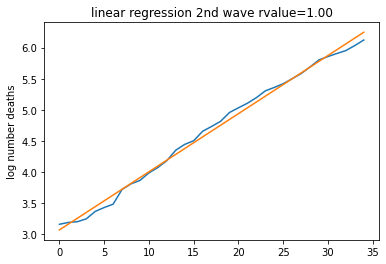

In [503]:
from scipy import stats

Y =  np.log(rolling_av[259:].tolist())
X = np.arange(len(Y))

plt.plot(X,Y);
coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept
plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('linear regression 2nd wave rvalue={:.2f}'.format(coeffs.rvalue))
plt.ylabel('log number deaths');
    

In [490]:
np.log(2)/a

7.418999454782632

---

## That's great


The exponential factor is quite big 
and the [doubling time](https://en.wikipedia.org/wiki/Doubling_time) is about a week !

You can see that on the graph below.
The the curves get twice as high every time.

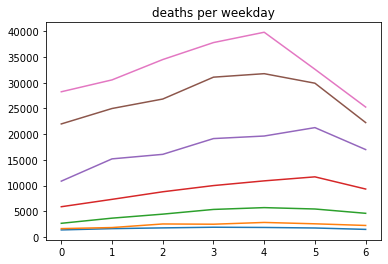

In [510]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

---

## Confirmed cases

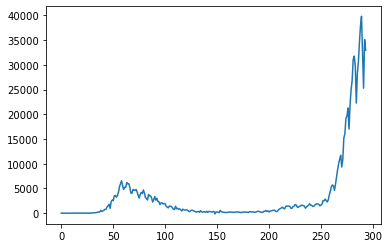

In [493]:
df = pd.read_csv('covid_confirmed.csv')

cases =  df.iloc[country][4:].values
daily = np.diff(cases, 1)
plt.plot(daily);

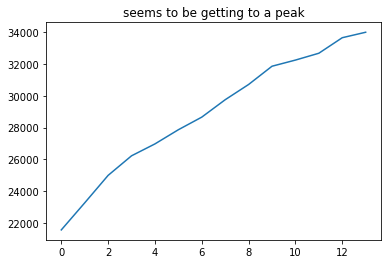

In [512]:

smoothed = np.convolve(daily, np.ones(7)/7)
plt.plot(smoothed[-20:-6]);
plt.title('seems to be getting to a peak');

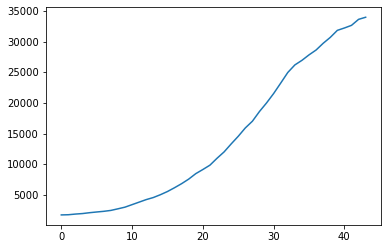

In [497]:
smoothed = np.convolve(daily, np.ones(7)/7)[:-6]
plt.plot(smoothed[250:]);

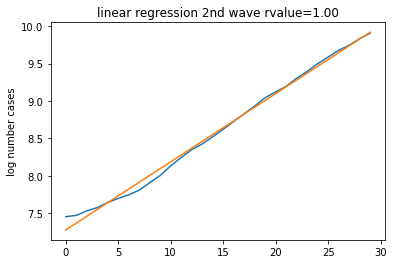

In [498]:
Y = smoothed[250:280].tolist()
X = np.arange(len(Y))

Y = np.log(Y)
plt.plot(X,Y)

coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept

plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('linear regression 2nd wave rvalue={:.2f}'.format(coeffs.rvalue))
plt.ylabel('log number cases');

In [499]:
np.log(2)/a, np.log(2)

(7.621043977754113, 0.6931471805599453)

# Mortality rate for the second wave

In [507]:
(deaths[-1] - deaths[250])/ (cases[-1] - cases[250])

0.009904331576158202

In [509]:
! ../.g

[master 0cd8917] web
 1 file changed, 64 insertions(+), 33 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 16.06 KiB | 967.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   7a2b10a..0cd8917  master -> master


---

# Game of life

I am going to program this using a convolution and boolean masks.

### References

[a blog](https://nicholasrui.com/2017/12/18/convolutions-and-the-game-of-life/#:~:text=The%20Game%20of%20Life%20is,its%20neighbors%20must%20be%20alive.)

---

The state of the game is represented by a 2D array ```G``` of integers 
$\in \{ 1,0 \}$.
- 0 is dead.
- 1 is alive.

There are four rules in the [game of life](https://fr.wikipedia.org/wiki/Jeu_de_la_vie#R%C3%A8gles).
We apply a convolution to G to obtain H 
which calculates the number of neighbors.


Now we modify the values in H so that they are either 0 or 1 :

- H[H<=2] = 0
- H[(H==4)&(G==0) ] = 0
- H[H>4] = 0
- H[H>0] = 1

---

### Test Code

I have coded a [planeur](https://fr.wikipedia.org/wiki/Planeur_(jeu_de_la_vie))
to test the code.

---

## Animation

I'm going to make an animation. 

- The helper functions  to do this  are in the next cell. 
- You should install [ffmpeg](https://ffmpeg.org/download.html).


In [322]:
import  matplotlib.animation
from matplotlib import animation

from IPython.display import HTML

##Animation code

def plot_images(img_list):
  def init():
    img.set_data(img_list[0])
    return (img,)

  def animate(i):
    img.set_data(img_list[i])
    return (img,)

  fig = plt.figure()
  ax = fig.gca()
  plt.axis('off')
  img = ax.imshow(img_list[0])

  anim = animation.FuncAnimation(fig, animate, 
                                 init_func=init,
                                 frames=len(img_list), 
                                 interval=200, 
                                 blit=True)
  return anim

## Set up 

- random starting configuration G
- the kernel K

In [277]:
G = np.random.randint(0,high=2, size=(10,10))
G

array([[1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 0]])

In [320]:
K = np.ones((3,3))
#K[1,1] = 0
K

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

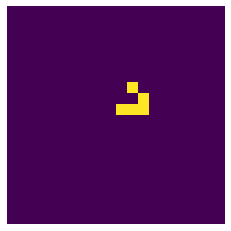

In [321]:
from scipy import signal


G = np.zeros((20,20), dtype=np.int0)
#G[3,4:7] = 1
#G[3:5,3:5] = 1

#G[3,4:7] = 1
#G[4,5:8] = 1

#this is a planeur/glider to test
G[4,5:8] = 1
G[3,7] = 1
G[2,6] = 1

#G = np.random.randint(0, high=2, size=(20,20))

frames = []
for k in range(100):
    H = signal.convolve2d( G, K, boundary='wrap')[1:-1,1:-1]

    H[H<=2] = 0
    H[(H==4)&(G==0) ] = 0
    H[H>4] = 0
    H[H>0] = 1
    G = H
    frames.append(np.copy(G))
    
HTML(plot_images(frames).to_html5_video())

---

# Exo

My code works but my  kernel  K doesn't calculate the number of neighbors

``` 
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])
```

There should be a 0 in the middle like this


``` 
array([[1., 1., 1.],
       [1., 0, 1.],
       [1., 1., 1.]])
```

1. Modify the code to use this kernel
1. According to the wikipedia :

L'état suivant d'une cellule est : (S = 3) OU (E = 1 ET S = 2).

Avec :

S : nombre actuel de cellules vivantes dans son voisinage (entier naturel compris entre 0 et 8 inclus) ;
E : état actuel de la cellule (entier naturel égal à 0 pour une cellule morte et égal à 1 pour une cellule vivante).

Rewrite the code to use this rule and so that there are just 3 lines in th ```for``` loop.


In [325]:
K[1,1] = 0
K

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

In [335]:
! ../.g

[master 98f81da] web
 1 file changed, 19 insertions(+), 24 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 573 bytes | 573.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   26c02a4..98f81da  master -> master
